# Training techniques for XGBoost tree.

| Technique | Parameter | Effect |
|-----------|-----------|--------|
|L1 Regularization | alpha | Prunes leaf weights to zero, making trees sparse.|
|L2 Regularization | lambda | Shrinks leaf weights, reducing their magnitude.|
|Maximum Depth | max_depth | Limits tree depth to prevent memorization of training data.|
|Minimum Child Weight | min_child_weight | Avoids splitting nodes with insufficient data, reducing the risk of small, overfitting nodes.|
|Subsampling | subsample, colsample_bytree | Randomly samples rows and features to prevent overfitting.|
|Early Stopping | early_stopping_rounds | Stops training once validation loss stops improving.|
|Learning Rate | eta | Slows down learning to improve generalization.|

# $$\text{Regularization}$$

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

In [39]:
class RegularizedPolynomialModel:
    def __init__(self, degree=1, lambda_l1=0.0, lambda_l2=0.0):
        self.degree = degree
        self.lambda_l1 = lambda_l1  # Współczynnik regularyzacji L1
        self.lambda_l2 = lambda_l2  # Współczynnik regularyzacji L2
        self.poly = PolynomialFeatures(degree)
        self.coef_ = None

    def _cost_function(self, w, X_poly, y):
        """
        Funkcja kosztu z regularyzacją L1 i L2.
        """
        # Obliczanie błędu średniokwadratowego
        residuals = y - np.dot(X_poly, w)
        mse = np.mean(residuals**2)

        # Regularyzacja L1 i L2
        l1_reg = self.lambda_l1 * np.sum(np.abs(w[1:]))  # Regularyzacja L1 (z wyjątkiem w_0)
        l2_reg = self.lambda_l2 * np.sum(w[1:] ** 2)  # Regularyzacja L2 (z wyjątkiem w_0)

        return mse + l1_reg + l2_reg

    def fit(self, X, y):
        """
        Trening modelu z regularyzacją.
        """
        # Przekształcenie cech na wielomianowe
        X_poly = self.poly.fit_transform(X)

        # Inicjalizacja wag
        initial_w = np.zeros(X_poly.shape[1])

        # Minimalizacja funkcji kosztu
        result = minimize(self._cost_function, initial_w, args=(X_poly, y))

        # Zapisanie wyuczonych wag
        self.coef_ = result.x

    def predict(self, X):
        """
        Predykcja na podstawie modelu.
        """
        X_poly = self.poly.transform(X)
        return np.dot(X_poly, self.coef_)

In [40]:
def generate_data():
    np.random.seed(42)
    X = np.linspace(1, 10, 20).reshape(-1, 1)
    y = 2 * np.log(X).ravel() + 0.5 * X.ravel() + np.random.normal(scale=1.2, size=X.shape[0])
    return X, y


def plot_model(X, y, model, ax=None):
    """
    Plot a single model on a given axis.
    If no axis is provided, create a new plot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))

    # Train the model
    model.fit(X, y)

    # Generate predictions
    X_plot = np.linspace(0, 10, 1000).reshape(-1, 1)
    y_plot = model.predict(X_plot)

    y_pred = model.predict(X)
    error = mean_squared_error(y, y_pred)

    # Plot data and the model's prediction
    ax.scatter(X, y, color="blue", alpha=0.6, label="Data")
    ax.plot(X_plot, y_plot, color="red", label=f"Model (degree {model.degree})")
    ax.set_title(f"Degree {model.degree}\nMSE: {error:.2f}")
    ax.set_xlabel("X")
    ax.set_ylabel("y")
    ax.legend()

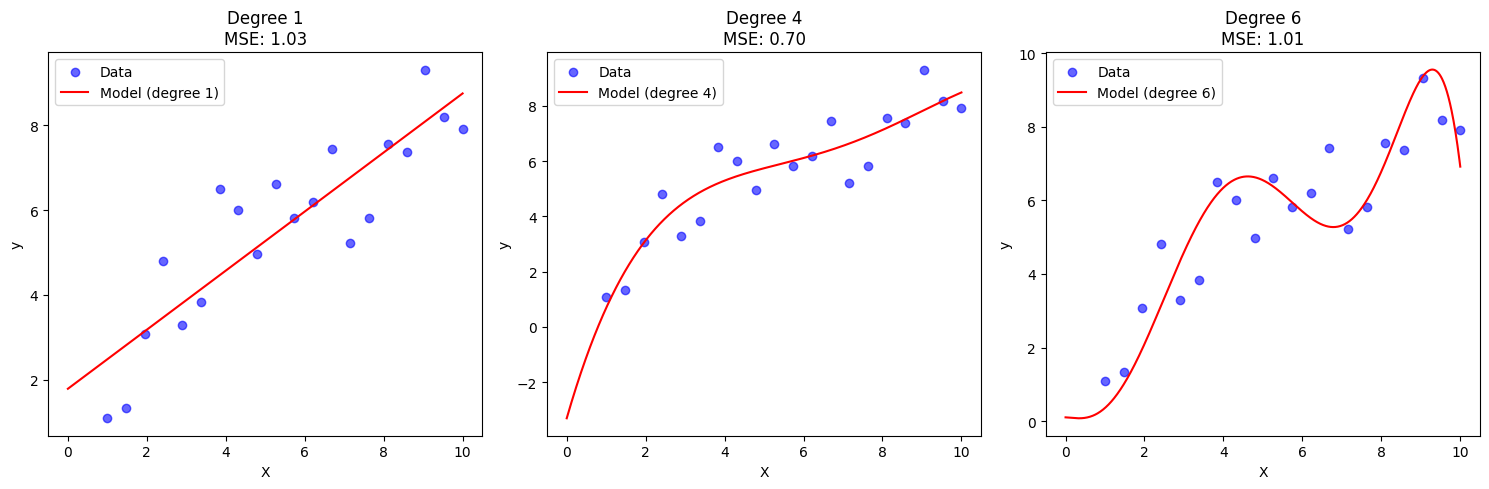

In [41]:
# Generate data
X, y = generate_data()

# Create models with different configurations
models = [
    RegularizedPolynomialModel(degree=1),  # Underfit
    RegularizedPolynomialModel(degree=4),  # Balanced fit
    RegularizedPolynomialModel(degree=6),  # Overfit
]

# Create subplots
fig, axes = plt.subplots(1, len(models), figsize=(15, 5))

# Plot each model on a separate subplot
for model, ax in zip(models, axes):
    plot_model(X, y, model, ax=ax)

plt.tight_layout()
plt.show()

# What's Happenning?

1. ***Underfitting***

    - What is it?

        - Underfitting happens when a model is too simple to capture the **underlying structure of the data**.
        - It fails to learn both the training data and the relationships in the data.
        
    - Symptoms:

        - The model has **high bias** (oversimplifies the problem).
        - Poor performance on both training and test data.
        - For example, using a straight line to model a dataset that follows a curved pattern.
        
    - Real-World Analogy:

        Imagine trying to understand a book by reading only its table of contents. You miss important details and fail to understand the core ideas.
        
    - In a Plot:

        The model does not follow the data points closely and leaves large errors.
        
1. ***Overfitting***

    - What is it?

        - Overfitting occurs when a model is too complex and starts learning not only the patterns but also the **noise and outliers** in the training data.
        - The model performs very well on the training data but **poorly on unseen data**.
        
    - Symptoms:

        - The model has **high variance** (too sensitive to small variations in the data).
        - Great performance on training data, but ****poor generalization to test data****.
        - For example, using a 15th-degree polynomial to model data that follows a quadratic trend.
        
    - Real-World Analogy:

        Imagine trying to memorize a book word-for-word to understand its content. While you know every detail, you fail to summarize or extract the main ideas, making it useless for understanding related topics.
        
    - In a Plot:

        The model zigzags excessively through every data point, resulting in unrealistic predictions for new data.
        
1. ***Balanced Fit***

    - What is it?

        - A balanced fit happens when the model captures the **true patterns in the data** without overemphasizing noise or ignoring important trends.
        - The model performs well on both training and test data.
        
    - Symptoms:

        - The model has a **good balance between bias and variance**.
        - Reasonable performance on both training and unseen data.
        - For example, using a quadratic curve to model a dataset that follows a quadratic trend.
        
    - Real-World Analogy:

        Imagine reading a book carefully, understanding its main ideas, and being able to summarize it effectively. You’ve captured the essence without getting bogged down in unnecessary details.
        
    - In a Plot:

        The model smoothly follows the data points, striking a **balance between simplicity and complexity**.

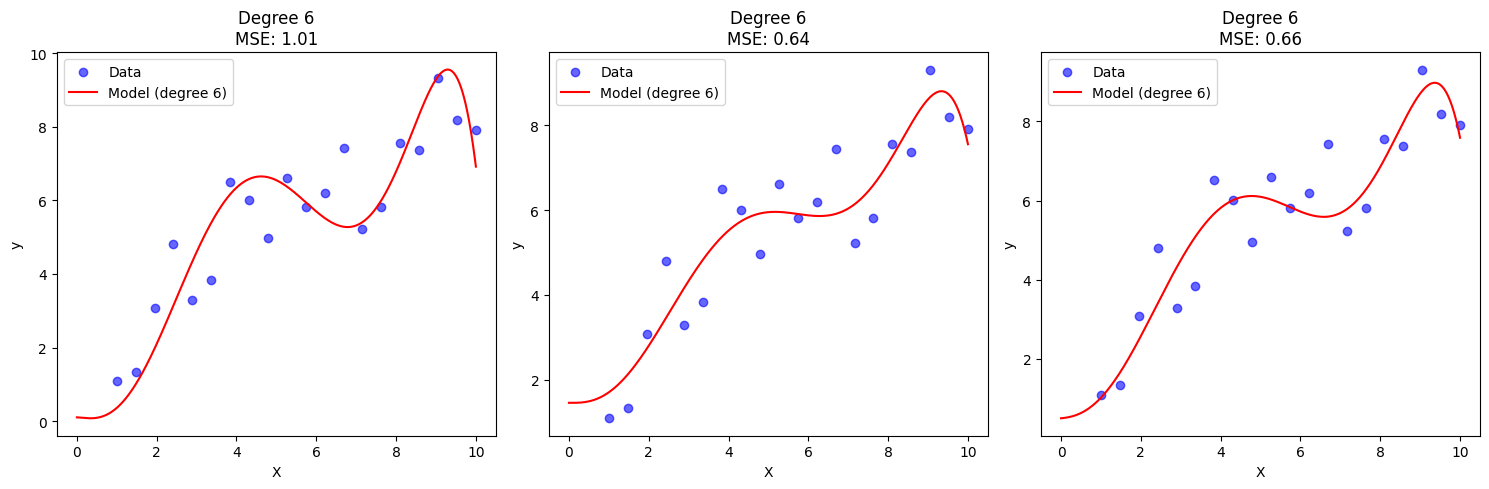

In [44]:
lambda_coeff = 1.7  # 5.

models = [
    RegularizedPolynomialModel(degree=6),
    RegularizedPolynomialModel(degree=6, lambda_l1=lambda_coeff),
    RegularizedPolynomialModel(degree=6, lambda_l2=lambda_coeff),
]

# Create subplots
fig, axes = plt.subplots(1, len(models), figsize=(15, 5))

# Plot each model on a separate subplot
for model, ax in zip(models, axes):
    plot_model(X, y, model, ax=ax)

plt.tight_layout()
plt.show()

# Regularization Techniques: L1 and L2

Regularization techniques, such as L1 and L2, are used in machine learning to prevent model overfitting and improve its ability to generalize. Both techniques involve adding a penalty (regularizer) to the cost function to constrain the magnitude of the model's weights, but they differ in their effects and implementation.

1. L1 Regularization (Lasso Regularization)

    **Definition**: 
    
    L1 regularization adds the sum of the absolute values of the weights to the cost function:

    $$J(\lambda, \theta) = Loss + \lambda \times \sum_{i = 1}^{n}|\theta_i| $$

    where $\lambda$ is the regularization coefficient that controls the strength of the penalty.
    
    **Intuition**:

    - L1 regularization encourages the weights to take on **exactly zero values**.
    - This effect is useful for automatic feature selection, as **features with zero weights are ignored** by the model.
    - This behavior arises because the absolute value function $|\theta_i|$ has a "sharp" peak at zero, promoting **sparse solutions** (many weights being zero).
    
    **Applications**:

    - Useful when an interpretable model is required, and you want to select **only the most important features**.
    - Commonly used in **high-dimensional data**, such as in genomics analysis.

2. L2 Regularization (Ridge Regularization)

    **Definition**: 

    L2 regularization adds the sum of the squared weights to the cost function:
    
    $$J(\lambda, \theta) = Loss + \lambda \times \sum_{i = 1}^{n}{\theta_i^2} $$

    **Intuition**:

    - L2 regularization reduces the magnitude of all weights but **does not** typically drive them to exactly zero.
    - It is smoother because the quadratic function does not have a sharp peak.
    - The model prefers solutions where the **weights are small but not sparse**.

    **Applications**:

    - Effective when **all features are important**, and you do not want to eliminate any of them.
    - More stable when working with **collinear data** (highly correlated features).

# $$\text{K-fold Cross Validation}$$

```
K-fold cross-validation splits the data into K subsets (or "folds"), and for each fold, **the model is trained on K−1 folds and tested on the remaining fold**. This method is used for **model validation** and XGBoost has built-in support for K-fold cross-validation.
```

## **K-fold Cross Validation step by step**:

1. Split the Data

    - The dataset is divided into **K folds** (subsets).
    - For example, with K=5, the dataset is split into 5 folds of roughly equal size.

2. Train and Validate

    - Train K models, each using **K−1 folds for training and 1 fold for validation**.
    - XGBoost optimizes the model on the training folds by creating boosted trees in an iterative fashion.
    - After each fold, XGBoost evaluates the model using a metric (e.g., accuracy, MSE) on the validation fold.

3. Aggregate Results

    - After all K iterations, aggregate the performance metrics (e.g., take the average).
    - Optionally, use these metrics to fine-tune XGBoost's hyperparameters (e.g., learning rate, max depth).

## **Advantages of K-fold Cross Validation**:

- ***Efficient Use of Data***: This method allows each data point to be used for **both training and testing**, maximizing the utility of the available data.
- ***Reduced Bias***: By training and testing the model **multiple times** on different subsets of the data, K-fold cross-validation reduces the bias that may result from using a single training/test split.
- ***More Stable Performance Estimates***: K-fold cross-validation gives an average performance score over all K iterations, which helps smooth out the effects of variability in the data. This often provides a more stable and generalizable performance metric than a single train-test split.


# $$Bootstrapping$$

XGBoost uses a technique similar to bootstrapping, specifically through **Stochastic Gradient Boosting** and **Subsampling**, which can be seen as a form of bootstrapping applied during the training of decision trees. Here's how it works:

1. Stochastic Gradient Boosting (Subsampling)

    In the standard version of gradient boosting (like the one used in XGBoost), each tree is built using all the available training data. However, in Stochastic Gradient Boosting (a variation used in XGBoost), the algorithm **introduces randomness by subsampling the training data for each tree**.

    - ***How it works***: Instead of training each tree on the entire training dataset, XGBoost randomly selects a subset of the data, **without replacement**, to train each individual tree. This is similar to bootstrapping in the sense that it creates variability in the model by training trees on different subsets of the data, though the main difference is that this subsampling is done without replacement (unlike bootstrapping, where sampling is done with replacement).

    - ***Key benefit***: This helps **prevent overfitting** and **improves the generalization ability** of the model by adding randomness to the process, which can also reduce model variance. Essentially, it ensures that **no individual tree overfits to the entire training set**, thus making the final ensemble model more robust.

1. Column Subsampling (Feature Subsampling)

    In addition to subsampling the data points, XGBoost also allows for subsampling features (i.e., randomly selecting a subset of features to build each tree). This method is akin to feature bagging in random forests.

    - ***How it works***: When growing each decision tree, XGBoost may only use a subset of features, chosen randomly, rather than using all available features. This adds further randomness and diversity in the trees, similar to the idea of bootstrapping where different sets of features or data points are used for training different models.

    - ***Key benefit***: This reduces overfitting by preventing the model from becoming **too reliant on specific features**. It also increases the diversity of the individual trees in the ensemble, which tends to improve the overall performance.

1. Similarity to Bootstrapping

    Both subsampling (data and feature) in XGBoost and bootstrapping share the concept of **introducing randomness into the model-building process**. While bootstrapping creates different datasets by resampling with replacement, subsampling in XGBoost randomly selects subsets of data or features to build each tree. Both methods aim to **reduce overfitting and enhance generalization**, but XGBoost typically uses subsampling without replacement, and it also uses an ensemble learning approach, where the trees are combined to form a strong predictive model.

1. Key Differences Between XGBoost Subsampling and Bootstrapping:

    - Bootstrapping: Sampling with replacement, so each training subset may have repeated data points and some data points may not be included.
    - XGBoost Subsampling: Sampling without replacement (for both data and features), so each subset is unique, and there is no repetition of data points in a given subset.

### Key Differences Between K-Fold Cross-Validation and Bootstrapping in XGBoost

|Aspect | K-Fold Cross-Validation | Bootstrapping (Subsampling)|
|---|---|---|
|Purpose | Evaluate model generalization. | Reduce overfitting and improve training efficiency.|
|When Applied | During model evaluation and hyperparameter tuning. | During model training, internally in XGBoost.|
|Data Usage | Split into folds for training and validation. | Random subsampling of rows and features in each iteration.|